In [ ]:
#@title Import del paper originale
%%capture
!pip -q install sentence_transformers ftfy
!git clone https://github.com/Event-AHU/VTF_PAR.git
!git clone https://github.com/KaiyangZhou/CoOp.git
%cd VTF_PAR
import torch.nn as nn
import torch
from CLIP.clip import clip
from models.vit import *
from CoOp import *
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

In [1]:
import numpy as np
import torch.nn as nn
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import importlib
import sys
sys.path.append('/content/drive/MyDrive/TESI/CODICE')
import fusion_transformer as fusion

In [ ]:
#@title Fusion Transformer
importlib.reload(fusion)
class TransformerClassifier(nn.Module):
  #attr_num è il numero di attributi che il modello PREVEDE, le classi di output
  # probabilmente è usato per costruire la Classification Head alla fine (avrà attr_num fully connected layers)
    def __init__(self, attr_num,attr_words, dim=768, checkpoint='vit_base_patch16_224'):
        super().__init__()
        super().__init__()
        self.attr_num = attr_num
        self.word_embed = nn.Linear(512, dim)
        self.visual_embed= nn.Linear(512, dim)
        self.vit = fusion.vit_base(num_heads = 2, depth = 2, embed_dim = dim, mlp_ratio = 2)
        self.vit.load_param(checkpoint)
        self.blocks = self.vit.blocks[-1:]
        self.norm = self.vit.norm
        self.weight_layer = nn.ModuleList([nn.Linear(dim, 1) for i in range(self.attr_num)])
        self.bn = nn.BatchNorm1d(self.attr_num)
        self.text = clip.tokenize(attr_words).to(device)

    def forward(self,videos,ViT_model):
        # ViT_features=[]
        # if len(videos.size())<5 :
        #     videos.unsqueeze(1)
        # batch_size, num_frames, channels, height, width = videos.size()
        # imgs=videos.view(-1, channels, height, width)
        # #imgs=videos[:,0,:,:,:]
        # for img in imgs:
        #     img=img.unsqueeze(0)
        #     ViT_features.append(ViT_model.encode_image(img).squeeze(0))
        # ViT_image_features=torch.stack(ViT_features).to(device).float()

        # _,token_num,visual_dim=ViT_image_features.size()
        # ViT_image_features=ViT_image_features.view(batch_size,num_frames,token_num,visual_dim)

        # ViT_image_features=self.visual_embed(torch.mean(ViT_image_features,dim=1))
        # text_features = ViT_model.encode_text(self.text).to(device).float()
        # textual_features = self.word_embed(text_features).expand(ViT_image_features.shape[0], text_features.shape[0],768)

        # x = torch.cat([textual_features,ViT_image_features], dim=1)

        # for b_c,blk in enumerate(self.blocks):
        #     x = blk(x)
        # x = self.norm(x)
        # logits = torch.cat([self.weight_layer[i](x[:, i, :]) for i in range(self.attr_num)], dim=1)
        # logits = self.bn(logits)
        return logits

fusion = TransformerClassifier(1,["The person is talking", "The person is not talking"])
trainable_params = sum(p.numel() for p in fusion.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

In [2]:
#@title My Fusion Transformer
import fusion_transformer as fusion
importlib.reload(fusion)
class MyTransformerClassifier(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio):
        # dim impatta molto la dimensione
        super().__init__()
        super().__init__()
        self.attr_num = 1 # Binary Classification
        self.word_embed = nn.Linear(512, dim)
        self.visual_embed= nn.Linear(512, dim)
        # num_heads & depth impattano abbastanza la dimensione
        # depth non ha alcuna importanza, prendo sempre comunque solo l'ultimo blocco
        self.vit = fusion.vit_base(num_heads = num_heads, depth = 1, embed_dim = dim, mlp_ratio = mlp_ratio)
        self.blocks = self.vit.blocks[-1:]
        self.norm = self.vit.norm
        self.weight_layer = nn.ModuleList([nn.Linear(dim, 1) for i in range(self.attr_num)])
        self.bn = nn.BatchNorm1d(self.attr_num)

    def forward(self, visual_emb, text_emb):
        ViT_image_features = self.visual_embed(visual_emb)
        textual_features = self.word_embed(text_emb)

        x = torch.cat([textual_features,ViT_image_features], dim=1)
        for b_c,blk in enumerate(self.blocks):
            x = blk(x)
        x = self.norm(x)
        logits = torch.cat([self.weight_layer[i](x[:, i, :]) for i in range(self.attr_num)], dim=1)
        logits = self.bn(logits)
        return logits

In [ ]:
out = fusion(vis_emb_tensor, txt_emb_tensor_repeated)
probabilities = torch.sigmoid(out)
probabilities

X SHAPE: torch.Size([5, 20, 512]) 


tensor([[0.6164],
        [0.6220],
        [0.6193],
        [0.6176],
        [0.6165]], grad_fn=<SigmoidBackward0>)

**Binary Classification Test**

Input: 5 Visual Emb talking + 5 Text Emb Talking

Output: ~50-51%

-----------

Input: 5 Visual Emb talking + 5 Text Emb NOT Talking

Output: ~53%

----------

Input: 5 Visual Emb NOT talking + 5 Text Emb NOT Talking

Output: ~54-55%



## Simulo il processing dei miei embeddings prima di passarli al modello

In [ ]:
vis_emb = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/H5_pretrained_ResNet.npy", allow_pickle=True).item()
text_emb = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/talking nottalking_emb.npy", allow_pickle=True).item()

In [ ]:
vis_emb_tensor = torch.stack([vis_emb[k][2] for k in list(vis_emb.keys())]).float()
txt_emb_tensor = torch.stack([text_emb[k][1] for k in list(text_emb.keys())]).float()

In [ ]:
keys_vis = list(vis_emb.keys())[1111:1116]
for k in keys_vis:
  print(f"{vis_emb[k][0]}    {vis_emb[k][1]}")
keys_txt = list(text_emb.keys())[0:5]
for k in keys_txt:
  print(f"{text_emb[k][0]}    ")

bell    0
bell    0
bell    0
bell    0
bell    0
This is a person who is not talking    
This is a person who is not talking    
This is a person who is not talking    
This is a person who is not talking    
This is a person who is not talking    


In [ ]:
# Attenzione che questi sono inizializzati a RANDOM
dim = 768
visual_embed= nn.Linear(512, dim)
word_embed = nn.Linear(512, dim)

In [ ]:
#@title Visual Embedding Processing
vis_emb_tensor = torch.stack([vis_emb[k][2] for k in keys_vis]).float()
txt_emb_tensor = torch.stack([text_emb[k][1] for k in keys_txt]).float()

# Aggiungo una finta dimensione "num_tokens" trattando l'intera immagine come una singola Patch
vis_emb_tensor = vis_emb_tensor.unsqueeze(1)
print(vis_emb_tensor.size())
# Trasformo la visual_dimension da 512 a 768
ViT_image_features = visual_embed(vis_emb_tensor) # Visual Embedding pronto ad essere concatenato
print(ViT_image_features.size())

torch.Size([5, 1, 512])
torch.Size([5, 1, 768])


In [ ]:
textual_features = word_embed(txt_emb_tensor).expand(ViT_image_features.shape[0], txt_emb_tensor.shape[0],768)
print(textual_features.size())

torch.Size([5, 5, 768])


In [ ]:
x = torch.cat([textual_features,ViT_image_features], dim=1)
x.size()

torch.Size([5, 6, 768])

In [ ]:
vis_emb = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Pretrained_ResNet_Patches.npy", allow_pickle=True).item()
text_emb = np.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/ViT_talking nottalking_emb.npy", allow_pickle=True).item()

In [ ]:
keys_vis = list(vis_emb.keys())#[0:5]
keys_txt = list(text_emb.keys())#[0:5]
vis_emb_tensor = torch.stack([vis_emb[k][2] for k in keys_vis]).float()
txt_emb_tensor = torch.stack([text_emb[k][1] for k in keys_txt]).float()
txt_emb_tensor = txt_emb_tensor.repeat(1, 10, 1)

In [ ]:
vis_emb_tensor = vis_emb_tensor.view(vis_emb_tensor.shape[0], 10, -1)
vis_emb_tensor.shape

torch.Size([13732, 10, 512])

In [ ]:
ViT_image_features = visual_embed(vis_emb_tensor) # Visual Embedding pronto ad essere concatenato
print(ViT_image_features.size())

torch.Size([5, 10, 768])


In [ ]:
txt_emb_tensor.size()

torch.Size([13738, 10, 512])

In [ ]:
txt_emb_tensor_repeated = txt_emb_tensor.repeat(1, 10, 1)
txt_emb_tensor_repeated.size()

torch.Size([5, 10, 512])

In [ ]:
textual_features = word_embed(txt_emb_tensor_repeated)#.expand(ViT_image_features.shape[0], ViT_image_features.shape[1],768)
print(textual_features.size())

torch.Size([5, 10, 768])


In [ ]:
x = torch.cat([textual_features,ViT_image_features], dim=1)
x.size()

torch.Size([5, 20, 768])

## TRAINING

In [285]:
vis_path = "/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_lieberman_patches.npy"
txt_path = "/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/ResNet_fixed_captions_emb.npy"
vis_dict = np.load(vis_path, allow_pickle=True).item()
text_dict = np.load(txt_path, allow_pickle=True).item()

In [286]:
keys_vis = sorted(list(vis_dict.keys()))
keys_txt = sorted(list(text_dict.keys()))
assert keys_vis == keys_txt, "Keys do not match"

In [287]:
excluded_person = "lieberman"

In [288]:
#@title LOAD TRAINING DATA
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# extract Visual (embedding, label) of chosen people
# MAKE SURE THAT THE EMBEDDINGS WITH THE SAME KEY ARE EXTRACTED IN THE SAME ORDER FROM VIS_EMB & TEXT_EMB
vis_emb_list = []
txt_emb_list = []
label_list = []

for k in keys_vis:
  if vis_dict[k][0] != excluded_person:
    vis_emb_list.append(vis_dict[k][2].clone().detach())
    label_list.append(vis_dict[k][1]) # same as text_emb labels anyway
    txt_emb_list.append(text_dict[k][2].clone().detach())

# ------- TRAIN TEST SPLIT ---------
data = list(zip(vis_emb_list, label_list, txt_emb_list))

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# back into individual lists
train_vis_emb_list, train_label_list, train_txt_emb_list = zip(*train_data)
val_vis_emb_list, val_label_list, val_txt_emb_list = zip(*val_data)
# ----------------------------------

train_vis_emb_tensor = torch.stack(train_vis_emb_list).float()
train_txt_emb_tensor = torch.stack(train_txt_emb_list).float()
train_label_tensor = torch.stack([torch.tensor(label) for label in train_label_list]).float()

val_vis_emb_tensor = torch.stack(val_vis_emb_list).float()
val_txt_emb_tensor = torch.stack(val_txt_emb_list).float()
val_label_tensor = torch.stack([torch.tensor(label) for label in val_label_list]).float()

# give both tensors shape [13732, 10, 512]
train_txt_emb_tensor = train_txt_emb_tensor.repeat(1, 10, 1)
val_txt_emb_tensor = val_txt_emb_tensor.repeat(1, 10, 1)


train_vis_emb_tensor = train_vis_emb_tensor.view(train_vis_emb_tensor.shape[0], 10, -1)
val_vis_emb_tensor = val_vis_emb_tensor.view(val_vis_emb_tensor.shape[0], 10, -1)
print(f"train_vis_emb: {train_vis_emb_tensor.size()} \t val_vis_emb: {val_vis_emb_tensor.size()}")
print(f"train_text_emb: {train_txt_emb_tensor.size()} \t val_text_emb: {val_txt_emb_tensor.size()}")
print(f"train_labels: {train_label_tensor.size()} \t\t val_labels: {val_label_tensor.size()}")

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_label_list), y=train_label_list)
class_weights = torch.tensor(class_weights).float().to(device)
print(f"Class weights: {class_weights}")

train_vis_emb: torch.Size([9671, 10, 512]) 	 val_vis_emb: torch.Size([2418, 10, 512])
train_text_emb: torch.Size([9671, 10, 512]) 	 val_text_emb: torch.Size([2418, 10, 512])
train_labels: torch.Size([9671]) 		 val_labels: torch.Size([2418])
Class weights: tensor([0.8863, 1.1472], device='cuda:0')


In [264]:
#@title CustomDataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, vis_emb_tensor, txt_emb_tensor, vis_label_tensor):
        self.vis_emb_tensor = vis_emb_tensor
        self.txt_emb_tensor = txt_emb_tensor
        self.vis_label_tensor = vis_label_tensor

    def __len__(self):
        return self.vis_emb_tensor.shape[0]

    def __getitem__(self, idx):
        return self.vis_emb_tensor[idx], self.txt_emb_tensor[idx], self.vis_label_tensor[idx]

In [252]:
#@title Set Seeds
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [232]:
#@title args
train_args = {
    'batch_size': 16,
    'epochs': 40,
    'learning_rate' : 0.0001,
    'weight_decay' : 0.001
}

model_args = {
    'num_heads': 2,
    'dim': 768, # The embed_dim should be divisible by num_heads
    'mlp_ratio': 2
}

In [277]:
#@title Training Function
from sklearn.metrics import precision_score, recall_score, f1_score

def CustomTraining(wandb_flag, batch_size, epochs, learning_rate, weight_decay, dim=512, num_heads=2, mlp_ratio=2):
  set_seed(0)

  model = MyTransformerClassifier(num_heads=num_heads, dim=dim, mlp_ratio=mlp_ratio).to(device)
  #model = MyTransformerClassifier2(depth=2, num_heads=num_heads, dim=dim, mlp_ratio=mlp_ratio).to(device)

  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Number of trainable parameters: {trainable_params}')

  # Create datasets
  train_dataset = CustomDataset(train_vis_emb_tensor, train_txt_emb_tensor, train_label_tensor)
  val_dataset = CustomDataset(val_vis_emb_tensor, val_txt_emb_tensor, val_label_tensor)

  # Create dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
  loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

  # Auto updates the LR if there is no improvement on the val_loss
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

  for epoch in range(epochs):
      # TRAINING
      model.train()

      correct_predictions = 0
      total_predictions = 0
      total_loss = 0

      for i, (vis_emb, txt_emb, labels) in enumerate(train_dataloader):
          vis_emb = vis_emb.to(device)
          txt_emb = txt_emb.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(vis_emb, txt_emb).squeeze()
          loss = loss_fn(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          probabilities = torch.sigmoid(outputs)
          predictions = (probabilities > 0.5).float()
          correct_predictions += (predictions == labels).sum().item()
          total_predictions += labels.size(0)
          total_loss += loss.item()

      # calculate and print average train metrics for the epoch...
      train_accuracy = correct_predictions / total_predictions
      train_loss = total_loss / len(train_dataloader)

      # VALIDATION
      model.eval()

      correct_predictions = 0
      total_predictions = 0
      total_loss = 0
      all_predictions = []
      all_labels = []

      with torch.no_grad():
        for i, (vis_emb, txt_emb, labels) in enumerate(val_dataloader):
            vis_emb = vis_emb.to(device)
            txt_emb = txt_emb.to(device)
            labels = labels.to(device)

            outputs = model(vis_emb, txt_emb).squeeze()
            loss = loss_fn(outputs, labels)

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            total_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

      # calculate and print average validation metrics for the epoch...
      val_accuracy = correct_predictions / total_predictions
      val_loss = total_loss / len(val_dataloader)

      # precision = precision_score(labels, predictions_binary)
      # recall = recall_score(labels, predictions_binary)
      all_predictions = np.concatenate(all_predictions)
      all_labels = np.concatenate(all_labels)
      f1_macro = f1_score(all_labels, all_predictions, average='macro') # Better For UNBALANCED data
      f1_weight = f1_score(all_labels, all_predictions, average='weighted')

      scheduler.step(val_loss)
      # free memory after each epoch
      torch.cuda.empty_cache()

      if wandb_flag:
        wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy,
                  "Validation Loss": val_loss, "Validation Accuracy": val_accuracy,
                    "Val F1-Macro Score": f1}
                  )

      # print('Epoch: {:d}'.format(epoch+1))
      # print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
      # print('\tValidation loss {:.5f}, Validation accuracy {:.2f}, Validation F1 {:.2f}'.format(val_loss, val_accuracy, f1))
      # print('-----------------------------------------------------')

  if wandb_flag: wandb.finish()
  return model, optimizer, f1_macro, f1_weight

In [ ]:
#@title RANDOM SEARCH
from sklearn.model_selection import ParameterSampler
import numpy as np

# 17 min per search
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32],
    'epochs': [40, 60], # <---- Provo con Sick con questa opzione
}

# Create the parameter grid
n_iter_search = 10  # Number of parameter settings that are sampled.
random_search = ParameterSampler(param_grid, n_iter=n_iter_search, random_state=0)

best_macro = 0
best_weighted = 0
best_macro_params = None
best_weight_params = None

for num, params in enumerate(random_search):
  print(f"--- {num} ---")
  model, _, macro, weighted  = CustomTraining(False, **params, **model_args)
  if macro > best_macro:
      best_macro = macro
      best_macro_params = params
      print(f"Found new best F1 MACRO: {macro} \t {params}")
  if weighted > best_weighted:
      best_weighted = weighted
      best_weight_params = params
      print(f"Found new best F1 WEIGHTED: {weighted} \t {params}")

print(f'\nbest F1 WEIGHTED: {best_weighted} with parameters: {best_weight_params}')
print(f'Found new best F1 MACRO: {best_macro} with parameters: {best_macro_params}')

In [289]:
best_macro_params = {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 40, 'batch_size': 32}

In [290]:
model, optimizer, _, _ = CustomTraining(False, **best_macro_params, **model_args)

Number of trainable parameters: 5517315


In [291]:
#@title Get TEST Data

vis_dict = np.load(vis_path, allow_pickle=True).item()
text_dict = np.load(txt_path, allow_pickle=True).item()

vis_emb_list = []
txt_emb_list = []
label_list = []
original_frames_list = []

for k in keys_vis:
  if vis_dict[k][0] == excluded_person:
    vis_emb_list.append(vis_dict[k][2].clone().detach())
    label_list.append(vis_dict[k][1]) # same as text_emb labels anyway
    txt_emb_list.append(text_dict[k][2].clone().detach())
    original_frames_list.append(text_dict[k][3])

test_vis_emb_tensor = torch.stack(vis_emb_list).float().view(len(vis_emb_list), 10, -1)
test_txt_emb_tensor = torch.stack(txt_emb_list).float().repeat(1, 10, 1)
test_label_tensor = torch.stack([torch.tensor(label) for label in label_list]).float()

print(f"Test Person: {excluded_person.upper()} ({sum(original_frames_list)} trajectories)")
print(f"test_vis_emb: \t{test_vis_emb_tensor.size()}")
print(f"test_text_emb: \t{test_txt_emb_tensor.size()}")
print(f"test_labels: \t{test_label_tensor.size()}")

Test Person: LIEBERMAN (16400 trajectories)
test_vis_emb: 	torch.Size([1643, 10, 512])
test_text_emb: 	torch.Size([1643, 10, 512])
test_labels: 	torch.Size([1643])


In [292]:
#@title Custom Test Dataset
from torch.utils.data import Dataset, DataLoader

class CustomTestDataset(Dataset):
    def __init__(self, vis_emb_tensor, txt_emb_tensor, vis_label_tensor, original_frames):
        self.vis_emb_tensor = vis_emb_tensor
        self.txt_emb_tensor = txt_emb_tensor
        self.vis_label_tensor = vis_label_tensor
        self.original_frames = original_frames

    def __len__(self):
        return self.vis_emb_tensor.shape[0]

    def __getitem__(self, idx):
        return self.vis_emb_tensor[idx], self.txt_emb_tensor[idx], self.vis_label_tensor[idx], self.original_frames[idx]

In [293]:
#@title Test Code
from sklearn.metrics import accuracy_score, f1_score

criterion = torch.nn.BCEWithLogitsLoss()

test_dataset = CustomTestDataset(test_vis_emb_tensor, test_txt_emb_tensor, test_label_tensor, original_frames_list)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()

with torch.no_grad():
    test_loss_total = 0
    batch_number = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    for i, (vis_emb, txt_emb, labels, original_frames) in enumerate(test_dataloader):
        vis_emb = vis_emb.to(device)
        txt_emb = txt_emb.to(device)
        labels = labels.to(device)

        outputs = model(vis_emb, txt_emb).squeeze()
        test_loss = criterion(outputs, labels.float())
        test_loss_total += test_loss.item()
        batch_number += 1

        outputs_prob = torch.sigmoid(outputs)
        predictions = (outputs_prob > 0.5).float().cpu()  # predictions for each batch
        # Repeat each prediction by the number of associated frames
        repeated_predictions = torch.repeat_interleave(predictions, original_frames)
        all_predictions.append(repeated_predictions.numpy())

        repeated_labels = torch.repeat_interleave(labels.cpu(), original_frames)
        all_labels.append(repeated_labels.numpy())

    # from lists of lists to lists of numbers
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    test_loss = test_loss_total / batch_number
    accuracy = accuracy_score(all_labels, all_predictions)
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

print("Test loss: ", round(test_loss,4))
print("Test Accuracy: ", round(accuracy,4))
print("F1 Weighted: ", round(f1_weighted,4))
print("F1 Macro: ", round(f1_macro,4))

Test loss:  0.0884
Test Accuracy:  0.973
F1 Weighted:  0.9727
F1 Macro:  0.9621


In [245]:
# INITIALIZE FINAL MATRIX
# final_cm = np.zeros((2, 2), dtype=int)

LIEBERMAN


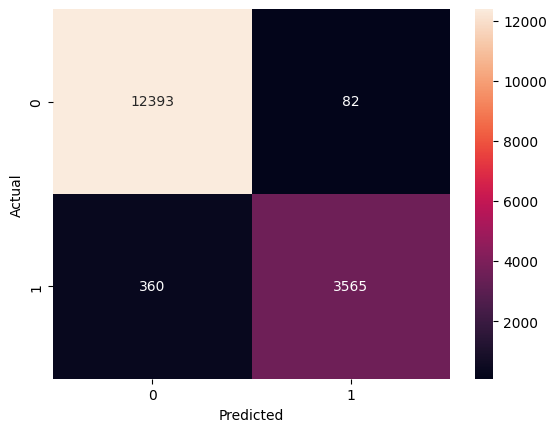

In [294]:
#@title CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert all_predictions and all_labels to numpy arrays if they aren't already
all_predictions_np = np.array(all_predictions)
all_labels_np = np.array(all_labels)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_np, all_predictions_np)

#Assuming cm is your confusion matrix
print(excluded_person.upper())
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

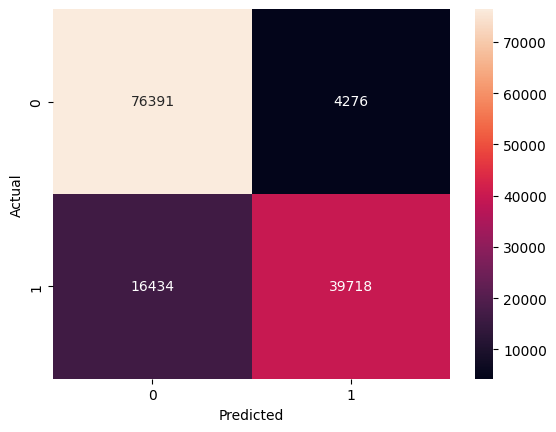

In [295]:
#@title UPDATE FINAL MATRIX
final_cm+=cm
sns.heatmap(final_cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#@title ---------------- Pretrained Emb - LONG Captions -----------------------
# Bell:
# Test loss:  1.1871
# Test Accuracy:  0.7668
# F1 Weighted:  0.7547
# F1 Macro:  0.7531
# Params: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 40, 'batch_size': 16}

# Sick:
# Test loss:  0.5984
# Test Accuracy:  0.7389
# F1 Weighted:  0.7381
# F1 Macro:  0.7388
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 40, 'batch_size': 16}

# Long:
# Test loss:  2.1051
# Test Accuracy:  0.5688
# F1 Weighted:  0.413
# F1 Macro:  0.3626
# Params: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 40, 'batch_size': 32}

# Bollinger:
# Test loss:  0.435
# Test Accuracy:  0.8731
# F1 Weighted:  0.8737
# F1 Macro:  0.8673
# Params: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 40, 'batch_size': 32}

# Lieberman:
# Test loss:  0.2698
# Test Accuracy:  0.9007
# F1 Weighted:  0.8912
# F1 Macro:  0.8395
# Params: {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 40, 'batch_size': 32}

In [ ]:
#@title ---------------- Pretrained RESNET - Fixed Captions -----------------------
# Bell:
# Test loss:  0.4281
# Test Accuracy:  0.8324
# F1 Weighted:  0.8323
# F1 Macro:  0.8321
# Params: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 40, 'batch_size': 16}

# Sick:
# Test loss:  0.4189
# Test Accuracy:  0.8258
# F1 Weighted:  0.8184
# F1 Macro:  0.8013
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 40, 'batch_size': 32}

# Long:
# Test loss:  0.4797
# Test Accuracy:  0.8095
# F1 Weighted:  0.7971
# F1 Macro:  0.7876
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 40, 'batch_size': 16}

# Bollinger:
# Test loss:  0.8038
# Test Accuracy:  0.8409
# F1 Weighted:  0.8428
# F1 Macro:  0.8369
# Params: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 40, 'batch_size': 16}

# Lieberman:
# Test loss:  0.2994
# Test Accuracy:  0.8971
# F1 Weighted:  0.8881
# F1 Macro:  0.8356
# Params: {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 40, 'batch_size': 32}

In [ ]:
#@title FINETUNED VIS EMB - LONG CAPTIONS

# Bell:
# Test loss:  0.3912
# Test Accuracy:  0.8562
# F1 Weighted:  0.8548
# F1 Macro:  0.8552
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.001, 'epochs': 40, 'batch_size': 32}

# Sick:
# Test loss:  0.2059
# Test Accuracy:  0.9245
# F1 Weighted:  0.925
# F1 Macro:  0.9209
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32}

# Long:
# Test loss:  0.3843
# Test Accuracy:  0.8656
# F1 Weighted:  0.8663
# F1 Macro:  0.865
# parameters: {'weight_decay': 0.0001, 'learning_rate': 0.01, 'epochs': 40, 'batch_size': 32}

# Bollinger:
# Test loss:  0.6055
# Test Accuracy:  0.801
# F1 Weighted:  0.7973
# F1 Macro:  0.7827
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32}

# Lieberman:
# Test loss:  0.1639
# Test Accuracy:  0.9382
# F1 Weighted:  0.9353
# F1 Macro:  0.9077
# parameters = {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 60, 'batch_size': 16}

In [ ]:
#@title FINETUNED VIS EMB - FIXED CAPTIONS

# Bell:
# Test loss:  0.6218
# Test Accuracy:  0.7965
# F1 Weighted:  0.7903
# F1 Macro:  0.7912
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32}

# Sick:
# Test loss:  0.3715
# Test Accuracy:  0.8668
# F1 Weighted:  0.8625
# F1 Macro:  0.8504
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32}

# Long:
# Test loss:  0.3615
# Test Accuracy:  0.8547
# F1 Weighted:  0.855
# F1 Macro:  0.8525
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32}


# Bollinger:
# Test loss:  0.4244
# Test Accuracy:  0.8078
# F1 Weighted:  0.8086
# F1 Macro:  0.7988
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32}

# Lieberman:
# Test loss:  0.0894
# Test Accuracy:  0.9771
# F1 Weighted:  0.9771
# F1 Macro:  0.9684
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 40, 'batch_size': 32}